# Data Augmentation

### NOTE!
Since the new tiles-and-patches approach, data augmentation by rotation, etc. is potentially redundant...

In [2]:
%reset
import numpy as np
import pandas as pd
import scipy.stats
import skimage.transform as tf
import pickle
from matplotlib import pyplot as plt
import math
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [226]:
def rotater(x_rot,y_rot):
    angle = np.random.uniform(30,330)
    for channel in range(x_rot.shape[0]):
        x_rot[channel,...] = tf.rotate(x_rot[channel,...],
                          angle=angle,
                          order=0,
                          mode='reflect')
    for class_ in range(y_rot.shape[0]):
        y_rot[class_,...] = tf.rotate(y_rot[class_,...].astype(np.float32),
                          angle=angle,
                          order=0,
                          mode='reflect')
    return x_rot[np.newaxis,...], y_rot[np.newaxis,...]

### The old method...
This section applied to loading the original 25 images, each resized to `(160,160)` and performing data augmentation on those.

In [220]:
img_w,img_h = (160,160)

def import_data(img_w,img_h):
    train_imgs = np.load('./data/training-data/train_imgs_{}x{}.npy'.format(img_w,img_h))[()]
        
    train_msks = np.load('./data/training-data/train_msks_{}x{}.npy'.format(img_w,img_h))[()]
        
    return train_imgs,train_msks

In [221]:
train_imgs,train_msks = import_data(img_w,img_h)

In [222]:
# This cell essentially shows the std of the proportions of each class
# This should get smaller if the data augmentation balances the classes better

areas = {}
# Tally the total area for each image and each class
for imageID in train_msks.keys():
    areas[imageID] = {}
    for class_ in range(train_msks[imageID].shape[0]):
        areas[imageID][class_] = train_msks[imageID][class_].sum()
areas = pd.DataFrame(areas).transpose()
# Determine if an image contains a class
areas_binary = areas.applymap(lambda x: 1 if x > 0 else 0)
# Find the relative proportion of each class, i.e. it's relative amount in the entire data set
areas_relative = pd.DataFrame([i/areas_binary.sum().sum() for i in areas_binary.sum()],columns=['proportion'])
(1-areas_relative).std()

proportion    0.048646
dtype: float64

In [5]:
# Find how "classy" an image is, i.e. whether it contains the all the classes
# Later, images that are not very "classy" will be chosen for augmentation with a lower frequency
# This will attempt to balance the classes a little
# Images with all classes get 1.0
# Images with few classes get lower scores, however rarer classes are preferred
classiness = dict(areas_binary.apply(lambda x: x*((1-areas_relative)/(1-areas_relative).sum()).proportion,axis=1).sum(axis=1))

In [224]:
# Make the x and y variables from train_imgs and train_msks

x = np.concatenate([i[np.newaxis,...] for i in train_imgs.values()],axis=0)
y = np.concatenate([i[np.newaxis,...] for i in train_msks.values()],axis=0)
print(x.shape,y.shape)

(25, 20, 160, 160) (25, 10, 160, 160)


In [2]:
# Alternatiely, load the pre-augmented data if I'm just here to make weights.
# Only run this if you've done the augmentation before and don't want to wait for it to run again

img_w,img_h = (160,160)
x = np.load('./data/training-data/train_imgs_{}x{}_augmented_array.npy'.format(img_w,img_h),'r')
y = np.load('./data/training-data/train_msks_{}x{}_augmented_array.npy'.format(img_w,img_h),'r')

In [ ]:
# Augment the data
# In this case, add 375 more values

for i in range(375):
    mu = np.mean(list(classiness.values()))
    sigma = np.std(list(classiness.values()))
    chance = scipy.stats.truncnorm.rvs((0-mu)/sigma,(1-mu)/sigma,loc=mu,scale=sigma)
    keys = [key for key in classiness if classiness[key]>chance]
    imageID = np.random.choice(keys)
    
    
    x_rot,y_rot = train_imgs[imageID].copy(),train_msks[imageID].copy()
    x_rot,y_rot = rotater(x_rot,y_rot)
    if np.random.uniform() > 0.25: # Flip LR
        x_rot = x_rot[:,:,:,::-1]
        y_rot = y_rot[:,:,:,::-1]
    if np.random.uniform() > 0.25: # Flip LR
        x_rot = x_rot[:,:,::-1,:]
        y_rot = y_rot[:,:,::-1,:]
        
    x = np.append(x,x_rot,axis=0)
    y = np.append(y,y_rot,axis=0)
    if i % 25 == 0:
        print('{} images are done.'.format(i))
print(x.shape,y.shape)

In [4]:
# Same as above but this is done on the augmented data set...
# The standard deviation should become lower...
# Which it does
areas = {}
for imageID in range(y.shape[0]):
    areas[imageID] = {}
    for class_ in range(y.shape[1]):
        areas[imageID][class_] = y[imageID,class_,...].sum()
areas = pd.DataFrame(areas).transpose()
areas_binary = areas.applymap(lambda x: 1 if x > 0 else 0)
areas_relative = pd.DataFrame([i/areas_binary.sum().sum() for i in areas_binary.sum()],columns=['proportion'])
(1-areas_relative).std()

proportion    0.032049
dtype: float64

### Processing before saving
Here we do simple processing, such as ensuring the masks are binary and that the data is shuffled

In [240]:
from sklearn.utils import shuffle
x,y = shuffle(x,y,random_state=13)

In [241]:
y[y>0] = 1

In [260]:
np.save('./data/training-data/train_imgs_{}x{}_augmented_array.npy'.format(img_w,img_h),x)
np.save('./data/training-data/train_msks_{}x{}_augmented_array.npy'.format(img_w,img_h),y)

### Making weights!
You need x/y values here, so if they're not loaded already (such as the case where the tiled-and-patched data is being used), load them first.

In [32]:
x = np.load('./data/training-data/tiled_patched_images_576_576.npy')
y = np.load('./data/training-data/tiled_patched_masks_576_576.npy')

In [33]:
print(x.shape,y.shape)

(324, 20, 160, 160) (324, 10, 160, 160)


In [34]:
# Original weights function

total_area = {}
for img in range(y.shape[0]):
    for class_ in range(y.shape[1]):
        if class_ not in total_area.keys():
            total_area[class_] = 0
        total_area[class_] += y[img,class_,...].sum()
weights = [area/np.sum(list(total_area.values())) for area in total_area.values()]
#weights = {class_:((np.min(list(weights.values()))-weight)/(np.min(list(weights.values()))-np.max(list(weights.values())))) for (class_,weight) in weights.items()}

In [35]:
[(weight/np.median(weights))**-1 for weight in weights]

[0.31473681513649232,
 0.72860964152689145,
 1.593567175602226,
 0.45548131861612789,
 0.099623956493461188,
 0.052842977254289283,
 2.7312575036684601,
 7.3879299975944193,
 188.12633996937214,
 29.256132412479161]

In [ ]:
np.save('./data/misc/augmented_data_class_weights.npy',weights)

In [36]:
# Newer weights function

class_areas = {} # the areas of class-specific pixels
total_areas = {} # the areas of all images that contain a class
for img in range(y.shape[0]):
    for class_ in range(y.shape[1]):
        
        if class_ not in class_areas.keys():
            class_areas[class_] = 0
        class_areas[class_] += y[img,class_,...].sum()
        
        if class_ not in total_areas.keys():
            total_areas[class_] = 0
        if y[img,class_,...].max() == 1:
            total_areas[class_] += y.shape[2]*y.shape[3] # total area of images

freqs = [area/total_areas[class_] for (class_,area) in class_areas.items()]
weights = np.array([np.median(freqs)/freq for freq in freqs])

In [43]:
list(weights)

[0.30823087464838361,
 1.0672203877881086,
 0.97708787599692914,
 1.0240124777381876,
 0.27402933718165551,
 0.076050966124010674,
 0.58147816148950038,
 3.3344898042245892,
 44.857843364734642,
 18.436538521677839]

In [44]:
np.save('./data/misc/weights.npy',weights)

9


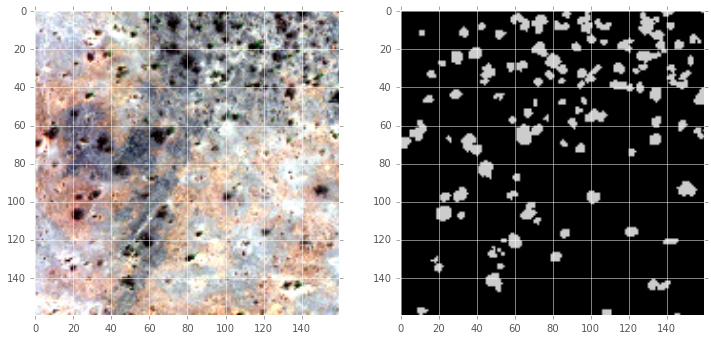

In [41]:
def plot_all(c):
    fig = plt.figure(figsize=(12,12))
    i = np.random.choice(x.shape[0])
    print(i)
    ax1 = fig.add_subplot(221)
    ax1.imshow(np.rollaxis(x[i,...],0,3)[:,:,:3])

    ax2 = fig.add_subplot(222)
    ax2.imshow(y[i,c,...],cmap='spectral')
    
    plt.show()
plot_all(4)
#push('PICTURES!','The plots are ready')